In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cv2
from bm3d import bm3d

# Super Resolution

$$\text{Input} : \rho_0, \lambda, \eta < 1, \gamma > 1\\$$
$$ \textbf{while} \text{ Not Converge} \textbf{ do}: $$
$$ x^{(k+1)} = \argmin_x f(x) + (\frac{\rho_k}{2}){||x - (v^{(k)} - u^{(k)})||}^2 $$
$$ v^{(k+1)} = \mathbb(D)_{\rho_k}(x^{(k+1)} + u^{(k)}), \text{where } \rho_k = \sqrt{\frac{\lambda}{\rho_k}} $$
$$  u^{(k+1)} = u^{(k)} + (x^{(k+1)} - v^{(k+1)}) $$
$$ \textbf{if } \Delta_{k+1} \geqslant \eta \Delta_k \textbf{then} : $$
$$ \rho_{k+1} = \gamma\rho_k $$
$$\textbf{else}$$
$$ \rho{k+1} = \rho_k $$
$$ \textbf{end if} $$
$$ k = k+1 $$

# Utility Functions

In [68]:
def upsample2(x, K):
    rows, cols = x.shape
    upsampled_x = np.zeros((rows*K, cols*K), dtype=float)
    upsampled_x[::K, ::K] = x
    return upsampled_x
def downsample2(x, K):
    return x[::K,::K]
def conv2(a, b, mode='full'):
    return scipy.signal.convolve2d(a, b, mode=mode)
def constructGGt(h, K, rows, cols):
    
    hth = conv2(h, np.rot90(h, 2), mode='full')
    
    yc = hth.shape[0] // 2
    xc = hth.shape[1] // 2
    
    L = hth.shape[0] // K
    
    if L % 2 == 0:
        L -= 1
    g = np.zeros((L, L))
    
    for i in range(-L // 2, L // 2 + 1):
        for j in range(-L // 2, L // 2 + 1):
            yi = yc + K * i
            xj = xc + K * j
            if 0 <= yi < hth.shape[0] and 0 <= xj < hth.shape[1]:
                g[i + L // 2, j + L // 2] = hth[yi, xj]
    
    GGt = np.abs(np.fft.fft2(g, s=(rows // K, cols // K)))
    
    return GGt
def fdown(x, h, K):
    tmp = scipy.signal.convolve2d(x, h, mode='same', boundary='wrap')
    y = downsample2(tmp, K)
    return y
def upf(x, h, K):
    tmp = upsample2(x, K)
    y = scipy.signal.convolve2d(tmp, h, mode='same', boundary='wrap')
    return y
def defGGt(h, K):
    G = fdown
    Gt = upf
    return G, Gt
def imresize(x, K, method='bilinear'):
    interpolation_methods = {
        'bilinear': cv2.INTER_LINEAR,
        'nearest': cv2.INTER_NEAREST,
        'bicubic': cv2.INTER_CUBIC,
        'lanczos': cv2.INTER_LANCZOS4
    }
    if method not in interpolation_methods:
        raise ValueError(f"Unknown interpolation method 'f{method}'")
    interpolation = interpolation_methods[method]

    new_size = (int(x.shape[1] * K), int(x.shape[0] * K))
    resized_x = cv2.resize(x, new_size, interpolation=interpolation)
    return resized_x
def proj(x, bound = [0, 1]):
    out = np.minimum(np.maximum(x, bound[0]), bound[1])
    return out
def wrapper_BM3D(x, sigma):
    return bm3d(x, sigma)
def fspecial(size, sigma, ftype='gaussian'):
    x = np.linspace(-size//2, size//2, size)
    x, y = np.meshgrid(x, x)
    h = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    h /= h.sum()
    return h
def imfilter(z, h, mode='wrap'):
    return scipy.ndimage.convolve(z, h, mode=mode)
def get_psnr(y_est: np.ndarray, y_ref: np.ndarray) -> float:
    if y_est.shape != y_ref.shape:
        y_est = cv2.resize(y_est, dsize=y_ref.T.shape)
    return 10 * np.log10(1 / np.mean(((y_est - y_ref).ravel()) ** 2))

# PnP ADMM algorithm

In [25]:
def PlugPlayADMM_super(y, h, K, lambda_, method, rho=1.0, gamma=1.0, maxitr=20, tol=1e-4):
    
    fft2 = scipy.fft.fft2
    ifft2 = scipy.fft.ifft2
    
    rows_in, cols_in = y.shape
    rows = rows_in * K
    cols = cols_in * K
    N = rows * cols

    G, Gt = defGGt(h, K)
    GGt = constructGGt(h, K, rows, cols)
    Gty = Gt(y, h, K)
    v = imresize(y, K)
    x = v.copy()
    u = np.zeros_like(v)
    residual = np.inf

    wrappers = {
        'BM3D': wrapper_BM3D,
        'TV': None,
        'NLM': None,
        'RF': None
    }
    denoise = wrappers[method]

    itr = 1
    while residual > tol and itr < maxitr:
        x_old = x
        v_old = v
        u_old = u

        x_tilde = v-u
        rhs = Gty + rho * x_tilde
        x = (rhs - Gt(ifft2(fft2(G(rhs, h, K)) / (GGt + rho)), h, K)) / rho

        v_tilde = x + u
        v_tilde = proj(v_tilde)
        sigma = np.sqrt(lambda_ / rho)
        v = denoise(v_tilde, sigma)

        u = u + (x - v)

        rho = rho * gamma

        residual_x = (1/np.sqrt(N))*(np.sqrt(np.sum(np.sum((x-x_old)**2))))
        residual_v = (1/np.sqrt(N))*(np.sqrt(np.sum(np.sum((v-v_old)**2))))
        residual_u = (1/np.sqrt(N))*(np.sqrt(np.sum(np.sum((u-u_old)**2))))

        residual = residual_x + residual_v + residual_u

        itr += 1
    return x

# Example

In [36]:
path = '/home/arnabdey/Placement_ML_projects/PnP/eye.jpg'
img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY) / 255.0

In [97]:
z = img
h = fspecial(size=5, sigma=1)
K = 3
noise_level = 10.0 / 255.0
y = imfilter(z, h)
y = downsample2(y, K)
y = y + noise_level * np.random.randn(y.shape[0], y.shape[1])

In [47]:
method = 'BM3D'
rho = 1
gamma = 1
lambda_ = 0.001
max_itr = 20
out = PlugPlayADMM_super(y=y, h=h, K=K, lambda_=lambda_, method=method)

/tmp/ipykernel_3989066/2791316204.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  upsampled_x[::K, ::K] = x


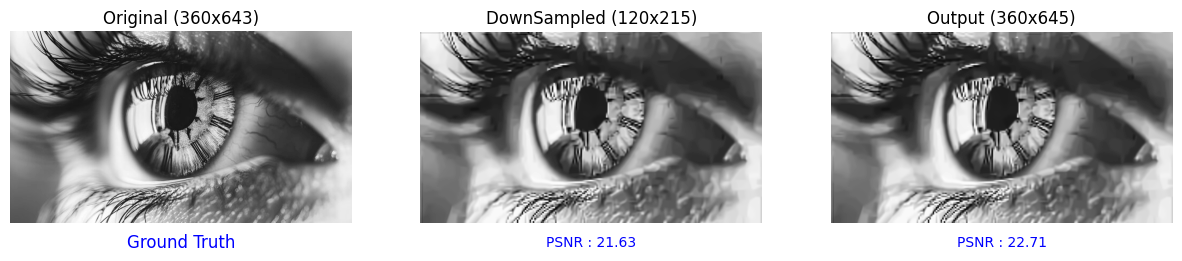

In [98]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

axes[0].imshow(img, cmap='gray')
axes[0].set_title(f"Original ({img.shape[0]}x{img.shape[1]})")
axes[0].text(0.5, -0.1, "Ground Truth", fontsize=12, color='blue', ha='center', va='center', transform=axes[0].transAxes)
# Display the second image
axes[1].imshow(out, cmap='gray')
axes[1].set_title(f"DownSampled ({y.shape[0]}x{y.shape[1]})")
axes[1].text(0.5, -0.1, f"PSNR : {np.round(get_psnr(y, img), 2)}", fontsize=10, color='blue', ha='center', va='center', transform=axes[1].transAxes)

axes[2].imshow(out, cmap='gray')
axes[2].set_title(f"Output ({out.shape[0]}x{out.shape[1]})")
axes[1].text(0.5, -0.1, f"PSNR : {np.round(get_psnr(out, img), 2)}", fontsize=10, color='blue', ha='center', va='center', transform=axes[2].transAxes)

for ax in axes:
    ax.axis('off')
# plt.tight_layout()
plt.show()
